In [1]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score , accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Define The Undersampling Technqiue from Khalila et. al

In [2]:
def three_class_partition(X,y, labels):
    'just a convenience method fit specifically for 3 class split of data'
    Xs, ys = [], []
    for lbl in labels:
        temp = X.iloc[np.where(y==lbl)]
        ytemp = y.iloc[np.where(y==lbl)]
        Xs.append(temp)
        ys.append(ytemp)
    return  Xs, ys 

def heatmap(data):
    " Just a convenience for calling heatmap later"
    im = ax.imshow(data, cmap = 'YlGnBu')
    ax.set_xticklabels = [0,1,2]
    ax.set_yticklabels = [0,1,2]

def repeated_subsample_training(X_train, y_train):
    ''' Iterate through majority datset, reuse the minority
    then function should return a stack of balanced classifiers '''
    # preparation steps
    counts = list(y_train.value_counts())
    num_models = int(max(counts) / min(counts))
    sample_size = min(counts)
    
    # build sets:
    '''if not maximum or minimum category, iterate through data once,
            then bootstrap'''
    stack = []
    Xs, ys = three_class_partition(X_train,y_train, labels = [0.0, 1.0, 2.0])
    
    X0, X1, X2 = Xs[0],Xs[1],Xs[2]
    
    for ii in range(num_models):

        if len(X0) > sample_size:
            part0 = X0.sample(sample_size)
            X0 = X0.drop(part0.index)

        if len(X2) > sample_size:
            part2 = X2.sample(sample_size)
            X2 = X2.drop(part2.index)

        else:
            part2 = Xs[2].sample(sample_size)
            X2 = Xs[2]
        
        X_ii = pd.concat( [part0, X1, part2])
        y_ii = pd.concat( [ pd.Series(np.zeros(sample_size)) , pd.Series(np.ones(sample_size)) , pd.Series(2*np.ones(sample_size)) ])  
        
        # Random Refined Parameter Selection over the Most Significant Parameters found from Previous Grid Search
        param_grid ={
            "n_estimators"      : [60,80,100],
            "max_depth"         : [28,32,34],
            "min_samples_split":  [2,4]
        }
        v1 = param_grid["n_estimators"][np.random.randint(3)]
        v2 = param_grid["max_depth"][np.random.randint(3)]
        v3 = param_grid["min_samples_split"][ii % 2]
        v4 = ["entropy","gini"][np.random.randint(2)]
        
        clf = RandomForestClassifier(n_estimators = v1, max_depth = v2, min_samples_split = v3, 
                                            min_samples_leaf = 1, criterion = v4)
        clf.fit(X_ii,y_ii)
        stack.append(clf)
        if ii % 10 == 0 : print(ii, "classifiers trained")
        
    return stack


def stack_prediction(stack, X_test, y_test, printout = False):
    num_cat = len(np.unique(y_test))
    votes =  np.zeros([len(y_test) , num_cat])
    probas = np.zeros( [len(y_test) , num_cat] )
    for n,m in enumerate(stack):
        y_pred = m.predict(X_test)
        y_proba = m.predict_proba(X_test)
        probas += y_proba
        # tallying loop
        for n,pred in enumerate(list(y_pred)):
            if num_cat > 2:
                votes[n,int(pred)] += 1
            if num_cat == 2:
                index = int(pred == 0)
                votes[n,index] += 1
            if(printout):
                print("Individual Model Performance " , n) 
                print("Accuracy: ", accuracy_score(y_test, y_pred))
                print("AUC: " , sklearn.metrics.roc_auc_score(y_test, y_proba, multi_class = 'ovr') )
                print("F1 Score: ", f1_score(y_test, y_pred, average = "macro"))
                print("")
    vote_pred = votes.argmax(axis = 1)
    # proba_pred = probas.argmax(axis = 1)
    # Probas is a likelihood for each class averaged from all predictors (slight difference from voting)
    
    print("done")
    
    return vote_pred, probas / len(stack)

### Load Standard Project Datasets

In [4]:
target = "Diabetes_012"
X_train = pd.read_csv("data/Dataset/train_012.csv")
X_test = pd.read_csv("data/Dataset/test_012.csv")
y_train = X_train[target]
y_test = X_test[target]
X_train.drop(target, axis = 1, inplace = True)
X_test.drop(target,axis = 1, inplace = True)
X_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,-0.059135,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.066667,0.000000,0.0,1.0,0.333333,1.0,0.857143
1,0.0,0.0,1.0,-0.663691,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.666667,1.0,0.428571
2,0.0,0.0,1.0,-1.268247,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.00,0.000000,0.133333,0.0,0.0,1.000000,0.6,0.142857
3,1.0,0.0,1.0,-0.059135,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.500000,0.8,0.714286
4,1.0,0.0,1.0,1.149976,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.100000,0.0,0.0,0.916667,0.8,0.428571


### Train the Undersampled Voter Model / Predict

In [5]:
### Train the "Stack of Experts" on undersampled data
model_stack = repeated_subsample_training(X_train, y_train)       
print("Models Generated: ", len(model_stack))

0 classifiers trained
10 classifiers trained
20 classifiers trained
30 classifiers trained
40 classifiers trained
Models Generated:  46
Making predictions...
done


In [12]:
print("Making predictions...")
votes, stack_probas = stack_prediction(model_stack, X_test, y_test)

Making predictions...
done


### Evaluate Undersampled Voting Model


Preview Probabilities
[[0.50368094 0.19376372 0.30255535]
 [0.57343639 0.28989848 0.13666514]
 [0.45294451 0.35669205 0.19036344]
 ...
 [0.10661426 0.35505031 0.53833543]
 [0.45641821 0.49701594 0.04656584]
 [0.28102931 0.53177861 0.18719207]]

Voter Evaluation: 
Accuracy:  0.6059799747713654
F1 Score:  0.6930312327298928
Precision  0.853783821681351
Recall:  0.6059799747713654 


Classification report
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75     42741
         1.0       0.03      0.36      0.05       926
         2.0       0.35      0.57      0.43      7069

    accuracy                           0.61     50736
   macro avg       0.44      0.52      0.41     50736
weighted avg       0.85      0.61      0.69     50736



Confusion:


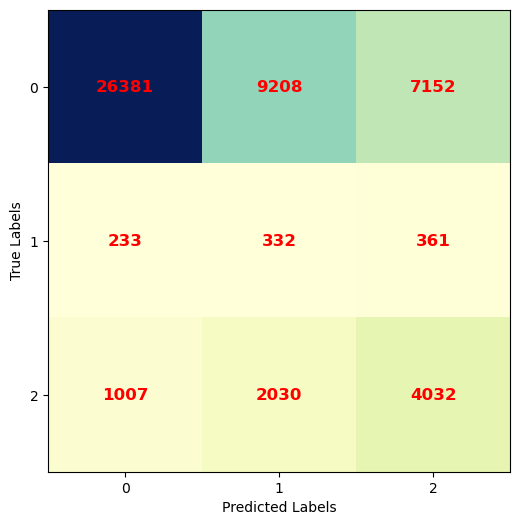

In [6]:
prob_votes= probas
print("\nPreview Probabilities")
print(probas)
print("\nVoter Evaluation: ")

print("Accuracy: ", accuracy_score(y_test, votes))
print("F1 Score: ", f1_score(y_test, votes, average = "weighted"))
print("Precision ",  sklearn.metrics.precision_score(y_test, votes, average = "weighted") )
print("Recall: ", sklearn.metrics.recall_score(y_test, votes, average = "weighted") , "\n\n")
print("Classification report")
print(sklearn.metrics.classification_report(y_test, votes))

print("\n\nConfusion:")

fig, ax = plt.subplots(figsize = (8,6))
# sns.heatmap(metrics.confusion_matrix(y_val, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
grid = sklearn.metrics.confusion_matrix(y_test, votes)
heatmap(grid)
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, grid[i, j],
                       ha="center", va="center", color="red",
                      font = {'weight' : 'bold', 'size'   : 12})

from matplotlib.ticker import MaxNLocator

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("Confidence_50percent_Threshold_Confusion.png")
plt.show()


### "Confidence" Analysis

In [17]:
def plot_conf_histograms(conf_df):
    fig, ax = plt.subplots(3,1, figsize = (8,8))
    for i in range(0,3):
        df = conf_df
        df = df[df.Diabetes_012 == i]
        print(df.head())

        ones = df["pre"]
        twos = df["diab"]
        zeros = df["non"]

        ax[i].hist(zeros, alpha = 0.3, color = "green", label = "Class 0 Probability")
        ax[i].hist(ones, alpha = 1, label = "Class 1 Probability")
        ax[i].hist(twos, alpha = 0.3 , color = "red", label = "Class 2 Probability")
        ax[i].set_yticks([])

        title = "True Class = {}".format(i)
        ax[i].set_title(str(title))
    fig.tight_layout()
    ax[0].legend(loc = "best")
    plt.show()
colnames = ["non", "pre", "diab"]

        non       pre      diab  Diabetes_012
0  0.503681  0.193764  0.302555           0.0
1  0.573436  0.289898  0.136665           0.0
2  0.452945  0.356692  0.190363           0.0
3  0.340083  0.308989  0.350929           0.0
4  0.147611  0.417118  0.435271           0.0
          non       pre      diab  Diabetes_012
13   0.191265  0.339718  0.469016           1.0
50   0.180242  0.408243  0.411515           1.0
110  0.183322  0.456330  0.360348           1.0
115  0.327415  0.384636  0.287949           1.0
150  0.168545  0.327813  0.503641           1.0
         non       pre      diab  Diabetes_012
5   0.168619  0.403728  0.427653           2.0
8   0.119946  0.417130  0.462924           2.0
17  0.219454  0.328245  0.452302           2.0
22  0.220097  0.323314  0.456589           2.0
25  0.083240  0.265501  0.651259           2.0


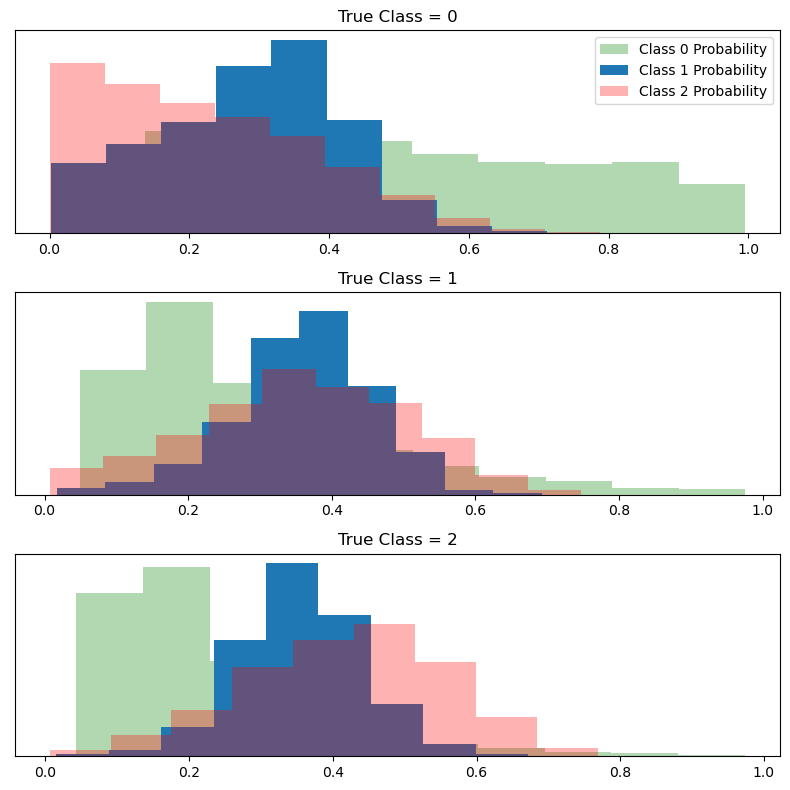

In [20]:
colnames = ["non", "pre", "diab"]
conf_df = pd.concat(  ( pd.DataFrame(stack_probas, columns =colnames) , pd.DataFrame(y_test) ) , axis = 1 )
plot_conf_histograms(conf_df)

## Comparison To "Normal" Model

        non       pre      diab  Diabetes_012
0  0.696667  0.000000  0.303333           0.0
1  0.958333  0.000000  0.041667           0.0
2  0.858333  0.100000  0.041667           0.0
3  0.934524  0.012500  0.052976           0.0
4  0.622500  0.113333  0.264167           0.0
          non       pre      diab  Diabetes_012
13   0.595833  0.041667  0.362500           1.0
50   0.691667  0.025000  0.283333           1.0
110  0.879167  0.025000  0.095833           1.0
115  0.897976  0.016667  0.085357           1.0
150  0.538690  0.000000  0.461310           1.0
         non     pre      diab  Diabetes_012
5   0.521667  0.0100  0.468333           2.0
8   0.652381  0.0125  0.335119           2.0
17  0.595833  0.0500  0.354167           2.0
22  0.736429  0.0000  0.263571           2.0
25  0.426667  0.0500  0.523333           2.0


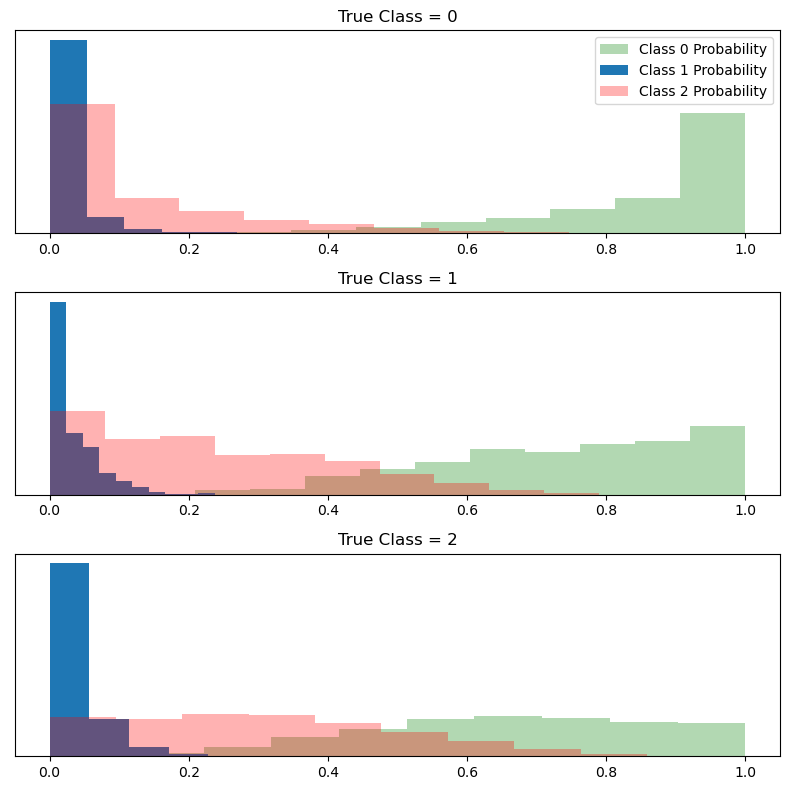

In [19]:
# from sklearn.linear_model import LogisticRegression
# log_reg = LogisticRegression(random_state=42,
#                                   C=0.1, penalty='l1', solver='saga')
# log_reg.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators = 20, max_depth = 100,
                                    min_samples_leaf = 1, min_samples_split = 4).fit(X_train, y_train)
probas = rf_clf.predict_proba(X_test)
conf_df = pd.concat(  ( pd.DataFrame(probas, columns =colnames) , pd.DataFrame(y_test) ) , axis = 1 )

plot_conf_histograms(conf_df)